In [1]:
# Importe de librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
from xgboost import XGBClassifier
import shap

In [2]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [232]:
# Input variables:
#    # bank client data:
#    1 - age (numeric)
#    2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
#                                        "blue-collar","self-employed","retired","technician","services") 
#    3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#    4 - education (categorical: "unknown","secondary","primary","tertiary")
#    5 - default: has credit in default? (binary: "yes","no")
#    6 - balance: average yearly balance, in euros (numeric) 
#    7 - housing: has housing loan? (binary: "yes","no")
#    8 - loan: has personal loan? (binary: "yes","no")
#    # related with the last contact of the current campaign:
#    9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
#   10 - day: last contact day of the month (numeric)
#   11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
#   12 - duration: last contact duration, in seconds (numeric)
#    # other attributes:
#   13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#   14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#   15 - previous: number of contacts performed before this campaign and for this client (numeric)
#   16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

#   Output variable (desired target):
#   17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [18]:
target_col = "y"
num_cols = ["age","balance","day","duration","campaign","pdays","previous"
]

cat_cols = [
"job","marital","education","default","housing","loan","contact","month","poutcome"
]

In [3]:
# Se crea esta función para validar que los datos que se recibiran a 
# futuro, están en linea con las variables de entreno o de estudio, asi mismo si existen nulos o no, y si es así revisar los casos puntales 
# Se transforma la variable Y categorica a numerical, se puede hacer porque es una variable ordinal
def validacion(data_frame,numerical_col,categorical_cols):
    data_frame["y"] = (data_frame["y"].astype(str).str.lower() == "yes").astype(int)
    required = set([target_col] + numerical_col + categorical_cols)
    if required != set(data_frame.columns):
        faltante = set(data_frame.columns).difference(required)
        sobrante = required.difference(set(data_frame.columns))
        raise ValueError(f"Col faltante: {faltante} , col sobrantes {sobrante}")
    else:
        print("Columnas coinciden: OK")

        
    nulos = data_frame.isnull().sum()
    columnas_con_nulos = nulos[nulos > 0]

    if not columnas_con_nulos.empty:
        raise ValueError(f"Col null: (columnas_con_nulos)")
    else:
        print("No existen columnas con Null: OK")


In [4]:
def plot_numeric_kde(dataframe, target="y"):
    n_cols = 3
    num_cols = dataframe.select_dtypes(include=['int64','float64']).columns.tolist()
    if target_col in num_cols:
        num_cols.remove(target_col)
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        sns.kdeplot(
            data=dataframe,
            x=col,
            hue=target,
            common_norm=False,
            fill=True,
            alpha=0.4,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {col} según {target}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Densidad")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
def plot_categorical_distribution(dataframe, target="y", n_cols=3, month_order=None):

    cat_cols = dataframe.select_dtypes(include=['object','category','bool']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    n_rows = int(np.ceil(len(cat_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        dist = (
            dataframe.groupby([col, target])
              .size()
              .reset_index(name="count")
        )
        dist["pct"] = dist.groupby(col)["count"].transform(lambda x: x / x.sum())
        
        # Manejar orden de meses
        if month_order is not None and col == "month":
            dist["month"] = pd.Categorical(dist["month"], categories=month_order, ordered=True)
            x_order = month_order
        else:
            x_order = None

        sns.barplot(
            data=dist,
            x=col,
            y="pct",
            hue=target,
            order=x_order,
            ax=axes[i]
        )
        axes[i].set_title(f"Distribución de {target} por {col}")
        axes[i].set_ylabel("Proporción")
        axes[i].tick_params(axis='x', rotation=45)

    # Eliminar subplots vacíos si los hay
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [5]:
def percent_box(data_frame):
    num_df = data_frame.select_dtypes(include=np.number)
    cols = num_df.columns
    n_cols = 3
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.violinplot(y=data_frame[col], ax=axes[i], inner=None, color="lightgray")
        sns.boxplot(y=data_frame[col], ax=axes[i], width=0.2, color="skyblue")
        axes[i].set_title(f"{col}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    
    return plt.show()

In [6]:
def resumen_por_categoria(data_frame, cat_cols, target='y'):
    for col in cat_cols:
        t = (
            data_frame
            .groupby(col)[target]
            .agg(
                y_1=lambda x: (x == 1).sum(),
                y_0=lambda x: (x == 0).sum(),
                total='size',
                rate='mean'
            )
            .sort_values('rate', ascending=False)
        )
        display(t)


In [223]:
tot_promedio = df['y'].mean()

In [17]:
X = df.drop(columns=['y'])
y = df[["y"]]


In [19]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


In [40]:
df_X.head(5)

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0.256419,-1.298476,0.011016,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.288529,-0.437895,-1.298476,-0.416127,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,-0.747384,-0.446762,-1.298476,-0.707361,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.571051,0.047205,-1.298476,-0.645231,-0.569351,-0.411453,-0.25194,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,-0.747384,-0.447091,-1.298476,-0.233620,-0.569351,-0.411453,-0.25194,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [7]:
def train_logit_cv_with_coefs(df, target='y', n_splits=5, random_state=42):

    feature_cols = [c for c in df.columns if c != target]
    X = df[feature_cols].copy()
    y = df[target].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])

    logit = LogisticRegression(
        max_iter=2000,
        class_weight='balanced'
    )

    pipe = Pipeline([
        ('pre', pre),
        ('clf', logit)
    ])

    cv = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=random_state
    )

    proba_cv = cross_val_predict(
        pipe, X, y, cv=cv, method='predict_proba'
    )[:, 1]

    auc = roc_auc_score(y, proba_cv)

    pipe.fit(X, y)
    feature_names = pipe.named_steps['pre'].get_feature_names_out()
    coefs = pipe.named_steps['clf'].coef_.ravel()
    coef_df = (
        pd.DataFrame({
            'feature': feature_names,
            'coef': coefs,
            'odds_ratio': np.exp(coefs)
        })
        .sort_values('odds_ratio', ascending=False)
        .reset_index(drop=True)
    )

    return {
        'auc': auc,
        'coef_df': coef_df,
        'pipeline': pipe
    }


In [8]:

def xgb_analysis(df, target_col, xgb_params=None, plot_shap=True):
    """
    Entrena un modelo XGBoost con preprocesamiento automático y genera métricas y gráfico SHAP.
    
    Parámetros:
    ----------
    df : pd.DataFrame
        DataFrame con los datos.
    target_col : str
        Nombre de la columna objetivo.
    xgb_params : dict, opcional
        Parámetros para XGBClassifier.
    plot_shap : bool
        Si True, genera el gráfico SHAP summary plot.
    
    Retorna:
    -------
    pipe_xgb : Pipeline
        Pipeline entrenado con preprocesamiento y modelo.
    auc : float
        ROC-AUC promedio en CV.
    ap : float
        Average Precision en CV.
    shap_values : np.array
        Valores SHAP del conjunto de entrenamiento.
    feature_names : list
        Lista de nombres de features tras el preprocesamiento.
    """
    
    # Separar X y y
    
    X = df.drop(columns=target_col)
    y = df[target_col].values

    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()


    # Preprocesamiento
    pre_xgb = ColumnTransformer([
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ])
    
    # Parámetros por defecto del XGBClassifier
    if xgb_params is None:
        xgb_params = {
            'n_estimators': 300,
            'max_depth': 4,
            'learning_rate': 0.05,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'eval_metric': 'logloss',
            'random_state': 42
        }
    
    xgb_model = XGBClassifier(**xgb_params)
    
    # Pipeline
    pipe_xgb = Pipeline([
        ('pre', pre_xgb),
        ('clf', xgb_model)
    ])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    proba_cv = cross_val_predict(pipe_xgb, X, y, cv=cv, method='predict_proba')[:,1]
    
    auc = roc_auc_score(y, proba_cv)

    
    # Entrenar pipeline completo
    pipe_xgb.fit(X, y)
    X_enc = pipe_xgb.named_steps['pre'].transform(X)
    
    # Obtener nombres de features
    ohe = pipe_xgb.named_steps['pre'].named_transformers_['cat']
    cat_features = ohe.get_feature_names_out(cat_cols)
    feature_names = num_cols + list(cat_features)
    
    # SHAP
    explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])
    shap_values = explainer.shap_values(X_enc)
    
    if plot_shap:
        shap.summary_plot(shap_values, X_enc, feature_names=feature_names, sort=True, show=True)
    
    return pipe_xgb, auc,  shap_values, feature_names


In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

def compute_oof_predictions(model_pipeline, X, y, cv=None):
    """
    Calcula predicciones fuera de la muestra (OOF) usando cross-validation.
    
    Parámetros:
    ----------
    model_pipeline : sklearn Pipeline
        Pipeline que contiene preprocesamiento y modelo.
    X : pd.DataFrame
        Variables predictoras.
    y : array-like
        Vector objetivo.
    cv : cross-validator, opcional
        Estrategia de cross-validation. Por defecto StratifiedKFold(5).

    Retorna:
    -------
    np.array
        Probabilidades OOF.
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    oof_probs = cross_val_predict(model_pipeline, X, y, cv=cv, method="predict_proba")[:, 1]
    return oof_probs


def simulate_targeting(df, y_col, score_col, top_fractions=(0.1, 0.2, 0.3), n_calls=10000):
    """
    Simula campañas de targeting priorizando a los clientes con mayor score.
    
    Parámetros:
    ----------
    df : pd.DataFrame
        DataFrame con variables predictoras, target y score.
    y_col : str
        Nombre de la columna objetivo.
    score_col : str
        Nombre de la columna de probabilidades o score.
    top_fractions : tuple
        Fracciones superiores a evaluar (ej. 0.1 = top 10%).
    n_calls : int
        Número de contactos simulados.

    Retorna:
    -------
    pd.DataFrame
        Resumen con lift, tasas de conversión y ventas esperadas.
    """
    baseline = df[y_col].mean()
    results = []

    for frac in top_fractions:
        threshold = df[score_col].quantile(1 - frac)
        segment = df[df[score_col] >= threshold].copy()
        segment_rate = segment[y_col].mean()
        lift = segment_rate / baseline if baseline > 0 else np.nan
        expected_if_called = n_calls * segment_rate
        expected_random = n_calls * baseline
        incremental = expected_if_called - expected_random

        results.append({
            "segment": f"Top {int(frac*100)}%",
            "threshold_score": threshold,
            "segment_size": len(segment),
            "baseline_rate": baseline,
            "segment_rate": segment_rate,
            "lift_x": lift,
            "expected_sales_if_call_n": expected_if_called,
            "expected_sales_random_n": expected_random,
            "incremental_sales_n": incremental
        })

    return pd.DataFrame(results).sort_values("segment")



feature_cols = [c for c in df.columns if c != "y"]
X = df[feature_cols].copy()
y = df["y"].values

# Calcular OOF predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
df["score_oof"] = compute_oof_predictions(pipe, X, y, cv=cv)

# Métricas de desempeño
auc = roc_auc_score(y, df["score_oof"])
ap = average_precision_score(y, df["score_oof"])
print(f"AUC (OOF): {auc:.3f} | Average Precision (OOF): {ap:.3f}")

# Simulación de targeting
summary = simulate_targeting(df, y_col="y", score_col="score_oof", top_fractions=(0.10, 0.20, 0.30), n_calls=10000)

# Formato más legible
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
display(summary[[
    "segment",
    "baseline_rate",
    "segment_rate",
    "lift_x",
    "expected_sales_if_call_n",
    "expected_sales_random_n",
    "incremental_sales_n"
]])

# Ejemplo detallado del top 10%
top_10 = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
print(
    f"Baseline: {top_10['baseline_rate']:.1%}. "
    f"Si priorizamos el {top_10['segment']} (score >= {top_10['threshold_score']:.3f}), "
    f"la conversión observada en ese segmento es {top_10['segment_rate']:.1%} "
    f"(lift x{top_10['lift_x']:.2f})."
)


NameError: name 'pipe' is not defined

In [11]:
def add_oof_scores(pipe, X, y, cv=None, score_col="score_oof"):

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    proba_oof = cross_val_predict(pipe, X, y, cv=cv, method="predict_proba")[:, 1]
    return proba_oof


def targeting_simulation(df, y_col, score_col, top_fracs=(0.10, 0.20, 0.30), n_calls=10000):

    baseline_rate = df[y_col].mean()

    out = []
    for frac in top_fracs:
        thr = df[score_col].quantile(1 - frac)
        seg = df[df[score_col] >= thr].copy()

        seg_rate = seg[y_col].mean()
        lift_vs_base = seg_rate / baseline_rate if baseline_rate > 0 else np.nan

        expected_sales_if_call = n_calls * seg_rate
        expected_sales_random = n_calls * baseline_rate

        out.append({
            "segment": f"Top {int(frac*100)}%",
            "threshold_score": thr,
            "segment_size": len(seg),
            "baseline_rate": baseline_rate,
            "segment_rate": seg_rate,
            "lift_x": lift_vs_base,
            "expected_sales_if_call_n": expected_sales_if_call,
            "expected_sales_random_n": expected_sales_random,
            "incremental_sales_n": expected_sales_if_call - expected_sales_random
        })

    return pd.DataFrame(out).sort_values("segment")



feature_cols = [c for c in df.columns if c not in ["y"]] 
X = df[feature_cols].copy()
y = df["y"].values 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
proba_oof = add_oof_scores(pipe, X, y, cv=cv, score_col="score_oof")

auc = roc_auc_score(y, proba_oof)
ap = average_precision_score(y, proba_oof)
print(f"AUC(OOF)={auc:.3f} | AP(OOF)={ap:.3f}")

df_sim = df.copy()
df_sim["score_oof"] = proba_oof

summary = targeting_simulation(
    df=df_sim,
    y_col="y",
    score_col="score_oof",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000
)

pd.set_option("display.float_format", lambda v: f"{v:,.3f}")
display(summary[[
    "segment",
    "baseline_rate",
    "segment_rate",
    "lift_x",
    "expected_sales_if_call_n",
    "expected_sales_random_n",
    "incremental_sales_n"
]])

row = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
print(
    f"Baseline={row['baseline_rate']:.1%}. "
    f"Si priorizamos el {row['segment']} (score >= {row['threshold_score']:.3f}), "
    f"la conversión observada en ese segmento es {row['segment_rate']:.1%} "
    f"(lift x{row['lift_x']:.2f})."
)


NameError: name 'pipe' is not defined

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score

def oof_targeting(
    df,
    pipe,
    target_col="y",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000,
    cv_splits=5
):
    # -------------------------
    # OOF predictions
    # -------------------------
    X = df.drop(columns=target_col)
    y = df[target_col].values

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    scores = cross_val_predict(
        pipe, X, y, cv=cv, method="predict_proba"
    )[:, 1]

    auc = roc_auc_score(y, scores)
    ap = average_precision_score(y, scores)

    # -------------------------
    # Targeting simulation
    # -------------------------
    df_sim = df.assign(score_oof=scores)
    baseline = df_sim[target_col].mean()

    rows = []
    for frac in top_fracs:
        thr = df_sim["score_oof"].quantile(1 - frac)
        seg = df_sim[df_sim["score_oof"] >= thr]

        seg_rate = seg[target_col].mean()

        rows.append({
            "segment": f"Top {int(frac*100)}%",
            "baseline_rate": baseline,
            "segment_rate": seg_rate,
            "expected_sales_if_call_n": n_calls * seg_rate,
            "expected_sales_random_n": n_calls * baseline,
            "incremental_sales_n": n_calls * (seg_rate - baseline)
        })

    summary = pd.DataFrame(rows)

    # -------------------------
    # Output
    # -------------------------
    print(f"AUC (OOF) = {auc:.3f} | AP (OOF) = {ap:.3f}")

    top10 = summary.loc[summary["segment"] == "Top 10%"].iloc[0]
    print(
        f"Baseline = {top10['baseline_rate']:.1%}. "
        f"Top 10% → conversión {top10['segment_rate']:.1%}."
    )

    return summary, auc, ap


In [396]:
summary, auc, ap = oof_targeting(
    df=df,
    pipe=pipe,
    target_col="y",
    top_fracs=(0.10, 0.20, 0.30),
    n_calls=10000
)

display(summary)


AUC (OOF) = 0.935 | AP (OOF) = 0.630
Baseline = 11.7%. Top 10% → conversión 63.2%.


,segment,baseline_rate,segment_rate,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.117,0.632,"6,322.424","1,169.848","5,152.576"
1,Top 20%,0.117,0.486,"4,857.901","1,169.848","3,688.053"
2,Top 30%,0.117,0.369,"3,688.440","1,169.848","2,518.592"


In [397]:
threshold = 0.833

df_sim["is_top10"] = (df_sim["score_oof"] >= threshold).astype(int)

df_top = df_sim[df_sim["is_top10"] == 1]
df_all = df_sim.copy()


In [13]:
def profile_categorical(df_all, df_seg, col, top_k=10):
    base_dist = (
        df_all[col]
        .value_counts(normalize=True)
        .rename("base_pct")
    )
    
    seg_dist = (
        df_seg[col]
        .value_counts(normalize=True)
        .rename("segment_pct")
    )
    
    out = (
        pd.concat([base_dist, seg_dist], axis=1)
        .fillna(0)
        .assign(
            diff_pct=lambda x: x["segment_pct"] - x["base_pct"],
            lift=lambda x: np.where(
                x["base_pct"] > 0,
                x["segment_pct"] / x["base_pct"],
                np.nan
            )
        )
        .sort_values("lift", ascending=False)
        .head(top_k)
    )
    
    return out


In [399]:
profile_categorical(df_all, df_top, "contact")

,base_pct,segment_pct,diff_pct,lift
contact,,,,
cellular,0.648,0.947,0.300,1.463
telephone,0.064,0.053,-0.012,0.817
unknown,0.288,0.000,-0.288,0.000


In [400]:
profile_categorical(df_all, df_top, "poutcome")

,base_pct,segment_pct,diff_pct,lift
poutcome,,,,
success,0.033,0.841,0.807,25.151
other,0.041,0.024,-0.017,0.579
failure,0.108,0.025,-0.083,0.234
unknown,0.817,0.111,-0.707,0.135


In [401]:
profile_categorical(df_all, df_top, "month")

,base_pct,segment_pct,diff_pct,lift
month,,,,
sep,0.013,0.165,0.152,12.873
mar,0.011,0.069,0.058,6.525
oct,0.016,0.096,0.080,5.882
dec,0.005,0.027,0.022,5.741
apr,0.065,0.120,0.055,1.844
feb,0.059,0.101,0.043,1.731
jun,0.118,0.159,0.041,1.349
aug,0.138,0.083,-0.055,0.603
jul,0.153,0.087,-0.066,0.570


In [402]:
profile_categorical(df_all, df_top, "job")

,base_pct,segment_pct,diff_pct,lift
job,,,,
student,0.021,0.112,0.092,5.414
unemployed,0.029,0.062,0.033,2.137
retired,0.050,0.105,0.055,2.098
management,0.209,0.281,0.072,1.342
admin.,0.114,0.143,0.029,1.251
self-employed,0.035,0.031,-0.004,0.882
technician,0.168,0.147,-0.021,0.873
unknown,0.006,0.005,-0.001,0.853
services,0.092,0.049,-0.043,0.532


In [87]:
profile_categorical(df_all, df_top, "month")
profile_categorical(df_all, df_top, "poutcome")
profile_categorical(df_all, df_top, "contact")
profile_categorical(df_all, df_top, "job")


,base_pct,segment_pct,diff_pct,lift
job,,,,
retired,0.050,0.115,0.065,2.294
student,0.021,0.065,0.044,3.125
management,0.209,0.248,0.038,1.184
unemployed,0.029,0.046,0.017,1.599
admin.,0.114,0.117,0.002,1.022
self-employed,0.035,0.037,0.002,1.061
unknown,0.006,0.006,-0.000,0.969
housemaid,0.027,0.021,-0.007,0.748
entrepreneur,0.033,0.022,-0.011,0.657


In [14]:
def profile_numeric(df_all, df_seg, col):
    return pd.DataFrame({
        "base_mean": [df_all[col].mean()],
        "segment_mean": [df_seg[col].mean()],
        "base_median": [df_all[col].median()],
        "segment_median": [df_seg[col].median()],
        "diff_mean": [df_seg[col].mean() - df_all[col].mean()]
    }, index=[col])


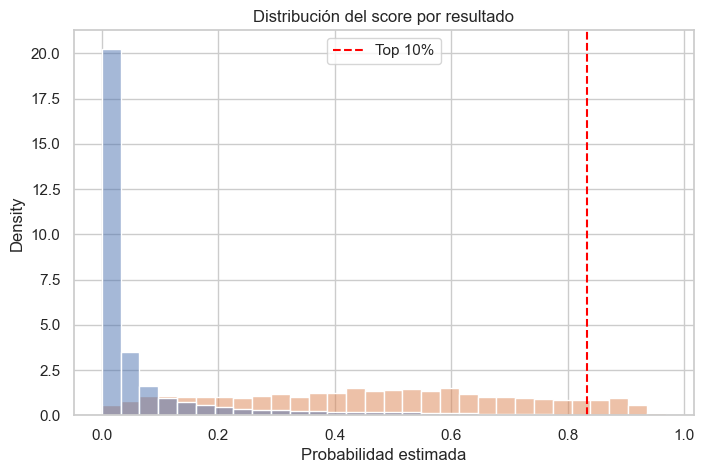

In [15]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [84]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

In [22]:
def main(
    dataframe, 
    target_col="y", 
    drop_cols=None, 
    show_plots=True
):
    """
    Función principal para ejecutar análisis completo:
    - Validación de datos
    - Eliminación de columnas opcionales
    - Gráficos opcionales de variables categóricas y numéricas
    - Entrenamiento de Logit y XGBoost con métricas y SHAP
    - OOF Targeting y segment profiling automático
    """
    
    # -----------------------------
    # 1. Detectar variables
    # -----------------------------
    num_cols = dataframe.select_dtypes(include=["int64","float64"]).columns.tolist()
    cat_cols = dataframe.select_dtypes(include=["object","category","bool"]).columns.tolist()
    
    if target_col in num_cols: 
        num_cols.remove(target_col)
    if target_col in cat_cols: 
        cat_cols.remove(target_col)
    
    # -----------------------------
    # 2. Eliminar columnas si se indica
    # -----------------------------
    if drop_cols is not None:
        dataframe = dataframe.drop(columns=drop_cols, errors='ignore')
    
    # -----------------------------
    # 3. Validación y gráficos
    # -----------------------------
    validacion(dataframe, num_cols, cat_cols)
    
    if show_plots:
        plot_categorical_distribution(dataframe)
        plot_numeric_kde(dataframe)
    
    # -----------------------------
    # 4. Regresión Logística
    # -----------------------------
    results = train_logit_cv_with_coefs(dataframe)
    print("Coeficientes regresión logística")
    print("Top 10")
    display(results['coef_df'].head(10))
    print("Últimos 10")
    display(results['coef_df'].tail(10))
    
    # -----------------------------
    # 5. XGBoost con SHAP
    # -----------------------------
    pipe, auc, shap_vals, feature_names = xgb_analysis(dataframe, target_col, plot_shap=show_plots)
    print(f"ROC-AUC CV: {auc:.3f}")
 
    
    # -----------------------------
    # 6. OOF Targeting
    # -----------------------------
    summary, auc_oof, ap_oof = oof_targeting(dataframe, pipe, target_col)
    print("\nOOF Targeting Summary:")
    display(summary)
    
    # -----------------------------
    # 7. Crear df_sim para segment profiling
    # -----------------------------
    df_sim = dataframe.copy()
    df_sim["score_oof"] = cross_val_predict(pipe, dataframe.drop(columns=target_col), dataframe[target_col].values,
                                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                                            method="predict_proba")[:,1]
    
    # Definir segmento Top 10%
    threshold = df_sim["score_oof"].quantile(0.90)
    df_top = df_sim[df_sim["score_oof"] >= threshold].copy()
    
    # -----------------------------
    # 8. Perfilado automático de variables numéricas
    # -----------------------------
    print("\nPerfil numérico del segmento Top 10%:")
    for col in num_cols:
        profile_df = profile_numeric(df_sim, df_top, col)
        print(f"\nColumna: {col}")
        display(profile_df)
    
    # -----------------------------
    # 9. Perfilado automático de variables categóricas
    # -----------------------------
    print("\nPerfil categórico del segmento Top 10%:")
    for col in cat_cols:
        profile_df = profile_categorical(df_sim, df_top, col)
        print(f"\nColumna: {col}")
        display(profile_df)
    plt.figure(figsize=(8,5))
    sns.histplot(
        data=df_sim,
        x="score_oof",
        hue="y",
        bins=30,
        stat="density",
        common_norm=False
    )
    plt.axvline(threshold, color="red", linestyle="--", label="Top 10%")
    plt.legend()
    plt.title("Distribución del score por resultado")
    plt.xlabel("Probabilidad estimada")
    plt.show()



In [23]:
ruta = "../Rindegastos/bank-full.csv"
df = pd.read_csv(ruta,sep=";")

Columnas coinciden: OK
No existen columnas con Null: OK
Coeficientes regresión logística
Top 10


,feature,coef,odds_ratio
0,cat__month_mar,1.837700,6.282074
1,cat__poutcome_success,1.816004,6.147244
2,num__duration,1.510004,4.526750
3,cat__month_oct,1.253217,3.501589
4,cat__month_sep,0.983505,2.673810
5,cat__job_student,0.704490,2.022814
6,cat__month_dec,0.659323,1.933483
7,cat__contact_cellular,0.545596,1.725636
8,cat__contact_telephone,0.505509,1.657829
9,cat__job_retired,0.470998,1.601591


Últimos 10


,feature,coef,odds_ratio
41,cat__poutcome_other,-0.378962,0.684571
42,cat__housing_yes,-0.396272,0.672824
43,cat__poutcome_failure,-0.603322,0.546992
44,cat__month_may,-0.702150,0.495519
45,cat__poutcome_unknown,-0.844273,0.429870
46,cat__month_aug,-0.881981,0.413962
47,cat__month_nov,-0.958155,0.383600
48,cat__contact_unknown,-1.061658,0.345882
49,cat__month_jul,-1.061971,0.345774
50,cat__month_jan,-1.295261,0.273826


ROC-AUC CV: 0.935
AUC (OOF) = 0.935 | AP (OOF) = 0.630
Baseline = 11.7%. Top 10% → conversión 63.2%.

OOF Targeting Summary:


,segment,baseline_rate,segment_rate,expected_sales_if_call_n,expected_sales_random_n,incremental_sales_n
0,Top 10%,0.116985,0.632242,6322.423706,1169.848046,5152.575660
1,Top 20%,0.116985,0.485790,4857.901139,1169.848046,3688.053093
2,Top 30%,0.116985,0.368844,3688.439988,1169.848046,2518.591942



Perfil numérico del segmento Top 10%:

Columna: age


,base_mean,segment_mean,base_median,segment_median,diff_mean
age,40.93621,42.444051,39.0,38.0,1.507841



Columna: balance


,base_mean,segment_mean,base_median,segment_median,diff_mean
balance,1362.272058,1914.160991,448.0,883.0,551.888933



Columna: day


,base_mean,segment_mean,base_median,segment_median,diff_mean
day,15.806419,15.255639,16.0,15.0,-0.55078



Columna: duration


,base_mean,segment_mean,base_median,segment_median,diff_mean
duration,258.16308,664.635781,180.0,562.5,406.472701



Columna: campaign


,base_mean,segment_mean,base_median,segment_median,diff_mean
campaign,2.763841,2.067227,2.0,1.0,-0.696614



Columna: pdays


,base_mean,segment_mean,base_median,segment_median,diff_mean
pdays,40.197828,80.535161,-1.0,-1.0,40.337333



Columna: previous


,base_mean,segment_mean,base_median,segment_median,diff_mean
previous,0.580323,1.409774,0.0,0.0,0.829451



Perfil categórico del segmento Top 10%:

Columna: job


,base_pct,segment_pct,diff_pct,lift
job,,,,
student,0.020747,0.061698,0.040951,2.973822
retired,0.050076,0.126493,0.076416,2.525999
unemployed,0.028820,0.041796,0.012975,1.450210
management,0.209197,0.244582,0.035385,1.169148
unknown,0.006370,0.006634,0.000264,1.041459
self-employed,0.034925,0.035825,0.000900,1.025762
admin.,0.114375,0.111897,-0.002477,0.978339
technician,0.168034,0.149491,-0.018543,0.889648
housemaid,0.027427,0.020345,-0.007082,0.741788



Columna: marital


,base_pct,segment_pct,diff_pct,lift
marital,,,,
single,0.282896,0.385449,0.102553,1.362512
divorced,0.115171,0.121406,0.006235,1.054140
married,0.601933,0.493145,-0.108789,0.819268



Columna: education


,base_pct,segment_pct,diff_pct,lift
education,,,,
tertiary,0.294198,0.391420,0.097221,1.330462
unknown,0.041074,0.051747,0.010673,1.259846
secondary,0.513194,0.441619,-0.071575,0.860530
primary,0.151534,0.115215,-0.036319,0.760322



Columna: default


,base_pct,segment_pct,diff_pct,lift
default,,,,
no,0.981973,0.99226,0.010287,1.010475
yes,0.018027,0.00774,-0.010287,0.429362



Columna: housing


,base_pct,segment_pct,diff_pct,lift
housing,,,,
no,0.444162,0.684432,0.24027,1.540951
yes,0.555838,0.315568,-0.24027,0.567734



Columna: loan


,base_pct,segment_pct,diff_pct,lift
loan,,,,
no,0.839774,0.922158,0.082385,1.098104
yes,0.160226,0.077842,-0.082385,0.485823



Columna: contact


,base_pct,segment_pct,diff_pct,lift
contact,,,,
cellular,0.647741,0.844980,0.197240,1.304504
telephone,0.064276,0.079832,0.015556,1.242010
unknown,0.287983,0.075188,-0.212795,0.261085



Columna: month


,base_pct,segment_pct,diff_pct,lift
month,,,,
mar,0.010551,0.063246,0.052696,5.994614
sep,0.012807,0.066342,0.053536,5.180316
dec,0.004733,0.024104,0.019371,5.092444
oct,0.016323,0.080274,0.063951,4.917720
apr,0.064851,0.110792,0.045940,1.708391
feb,0.058592,0.076073,0.017481,1.298345
jun,0.118135,0.106811,-0.011324,0.904145
jan,0.031032,0.027421,-0.003611,0.883644
aug,0.138174,0.117647,-0.020527,0.851439



Columna: poutcome


,base_pct,segment_pct,diff_pct,lift
poutcome,,,,
success,0.033421,0.261831,0.228410,7.834311
other,0.040698,0.060150,0.019452,1.477967
failure,0.108403,0.108801,0.000399,1.003677
unknown,0.817478,0.569217,-0.248261,0.696309


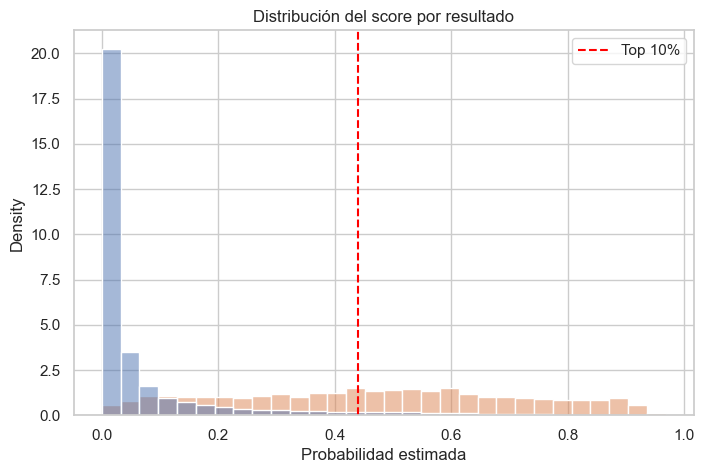

In [24]:
main(
    dataframe=df,        # tu DataFrame
    target_col="y",      # nombre de la columna objetivo
    drop_cols=None,    # si quieres eliminar columnas opcionales (puede ser None)
    show_plots=False      # True para mostrar gráficos, False para no mostrarlos
)